# Harmony Concise + L2SS-Py Demo

## What is Concise?
Concise is a Harmony service developed by PODAAC that allows users to concatenate multiple L2 granules together into a single granule. This concatenation is done by adding a new `subset_index` dimension to the resulting granule.

## What is L2SS-Py + Concise?
Harmony supports chaining multiple services together. The L2SS-Py + Concise chain allows users to combine spatial, temporal, and variable subsetting with granule concatenation.


## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: [Authentication for NASA Earthdata](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html#authentication-via-netrc-file).

## Running the Demo

The remaining notebook walks through constructing a request that first subsets multiple files from a collection and then concatenates the results together into a single output file. This is accomplished using the [Harmony](https://harmony.earthdata.nasa.gov/) coverages API through the use of the [harmony-py](https://github.com/nasa/harmony-py) python library.

The collection being used in the demonstration is the [ASCATB-L2-25km](https://podaac.jpl.nasa.gov/dataset/ASCATB-L2-25km?ids=&values=&search=C2075141559-POCLOUD&provider=POCLOUD) collection which contains operational near-real-time Level 2 ocean surface wind vector retrievals from the Advanced Scatterometer (ASCAT) on MetOp-B at 25 km sampling resolution.

The first step is to import the libraries needed to run the demo.

In [1]:
import xarray as xr
import tempfile
from IPython.display import display, JSON
from datetime import datetime, timedelta, time
from harmony import BBox, Client, Collection, Request, Environment, LinkType

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Create Harmony-py client.

In [2]:
harmony_client = Client(env=Environment.PROD)

With the client created, we can contruct and validate the request. As this is a subsetting + concatenation request, we specify options on the request that define spatial bounds, variables we are interested in, temporal bounds, and indicated the result should be concatenated. Since this is a near real time dataset, we will request the data from yesterday.

In [3]:
collection = Collection(id='C2075141559-POCLOUD')

yesterday = datetime.today() - timedelta(days=1)

request = Request(
    collection=collection,
    spatial=BBox(-180, -30, 180, 30),
    variables=[
        'wind_speed', 
        'wind_dir'
    ],
    temporal={
        'start': datetime.combine(yesterday, time.min),
        'stop': datetime.combine(yesterday, time.max)
    },
    concatenate=True
)

request.is_valid()

True

Now that we have a valid request we simply need to call the `submit` function using the client we created earlier and pass in the request as a parameter.

_Tip:_ if you want to see the request before submitting it, use the `request_as_curl` function on the client to get an equivalent curl command for the request that will be submitted.

In [4]:
print(harmony_client.request_as_curl(request))
job_id = harmony_client.submit(request)
print(f'Job ID: {job_id}')

curl -X GET -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate' -H 'Connection: keep-alive' -H 'Cookie: urs_user_already_logged=yes; token=*****; _urs-gui_session=046f3430c6ca2f9e3e00d94c0bee2f70' -H 'User-Agent: Windows/10 harmony-py/0.4.2 CPython/3.8.12 python-requests/2.25.1' 'https://harmony.earthdata.nasa.gov/C2075141559-POCLOUD/ogc-api-coverages/1.0.0/collections/wind_speed,wind_dir/coverage/rangeset?forceAsync=true&subset=lat%28-30%3A30%29&subset=lon%28-180%3A180%29&subset=time%28%222022-10-19T00%3A00%3A00%22%3A%222022-10-19T23%3A59%3A59.999999%22%29&concatenate=true'
Job ID: 87ec4775-7949-482c-96b2-11f5e6941d15


After submitting the request it is possible to retrieve the current processing status by using the job ID returned from the submission.

In [5]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2022, 10, 20, 22, 45, 28, 721000, tzinfo=tzutc()),
 'updated_at': datetime.datetime(2022, 10, 20, 22, 45, 29, 72000, tzinfo=tzutc()),
 'created_at_local': '2022-10-20T15:45:28-07:00',
 'updated_at_local': '2022-10-20T15:45:29-07:00',
 'data_expiration': datetime.datetime(2022, 11, 19, 22, 45, 28, 721000, tzinfo=tzutc()),
 'data_expiration_local': '2022-11-19T14:45:28-08:00',
 'request': 'https://harmony.earthdata.nasa.gov/C2075141559-POCLOUD/ogc-api-coverages/1.0.0/collections/wind_speed,wind_dir/coverage/rangeset?forceAsync=true&subset=lat(-30%3A30)&subset=lon(-180%3A180)&subset=time(%222022-10-19T00%3A00%3A00%22%3A%222022-10-19T23%3A59%3A59.999999%22)&concatenate=true',
 'num_input_granules': 16}

If the request is still running, we can wait until the Harmony request has finished processing. This cell will wait until the request has finised.

In [6]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Now that the request has completed we can inspect the results using [xarray](https://xarray.pydata.org/en/stable/) and [matplotlib](https://matplotlib.org/).

First, let's download the result into a temporary directory

In [7]:
temp_dir = tempfile.mkdtemp()
futures = harmony_client.download_all(job_id, directory=temp_dir, overwrite=True)
file_names = [f.result() for f in futures]
file_names

['C:\\Users\\nickles\\AppData\\Local\\Temp\\tmpqzco2nld\\C2075141559-POCLOUD_merged.nc4']

With the output file downloaded, now we can open concatenated granule using xarray to inspect some of the metadata. 

Notice the variable subset has been successfully executed -- only `wind_dir` and `wind_speed` vars are present. In addition, there is a new dimension `subset_index` added to each variable in the dataset. The index of this dimension corresponds to the original file named in the `subset_files` variable that contained the data at that index.

In [8]:
ds = xr.open_dataset(file_names[0], decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (subset_index: 16, NUMROWS: 596, NUMCELLS: 42)
Coordinates:
    lat           (subset_index, NUMROWS, NUMCELLS) float32 ...
    lon           (subset_index, NUMROWS, NUMCELLS) float32 ...
Dimensions without coordinates: subset_index, NUMROWS, NUMCELLS
Data variables:
    subset_files  (subset_index) object ...
    time          (subset_index, NUMROWS, NUMCELLS) float64 ...
    wind_speed    (subset_index, NUMROWS, NUMCELLS) float32 ...
    wind_dir      (subset_index, NUMROWS, NUMCELLS) float32 ...
Attributes: (12/18)
    title:                            MetOp-B ASCAT Level 2 25.0 km Ocean Sur...
    title_short_name:                 ASCATB-L2-25km
    Conventions:                      CF-1.6
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-B ASCAT
    software_identification_level_1:  1000
    ...                               ...
    processing_level:                 L2
    rev_orbit_period:                 6081.7
    orbit_inclination:                98.7
    references:                       ASCAT Wind Product User Manual, https:/...
    comment:                          Orbit period and inclination are consta...
    history_json:                     [{"date_time": "2022-10-20T22:45:37.904...

Using matplotlib, we can genearte a plot for each granule that makes up this concatenated granule. Plot `wind_speed` for each granule using `subset_index` dimension.

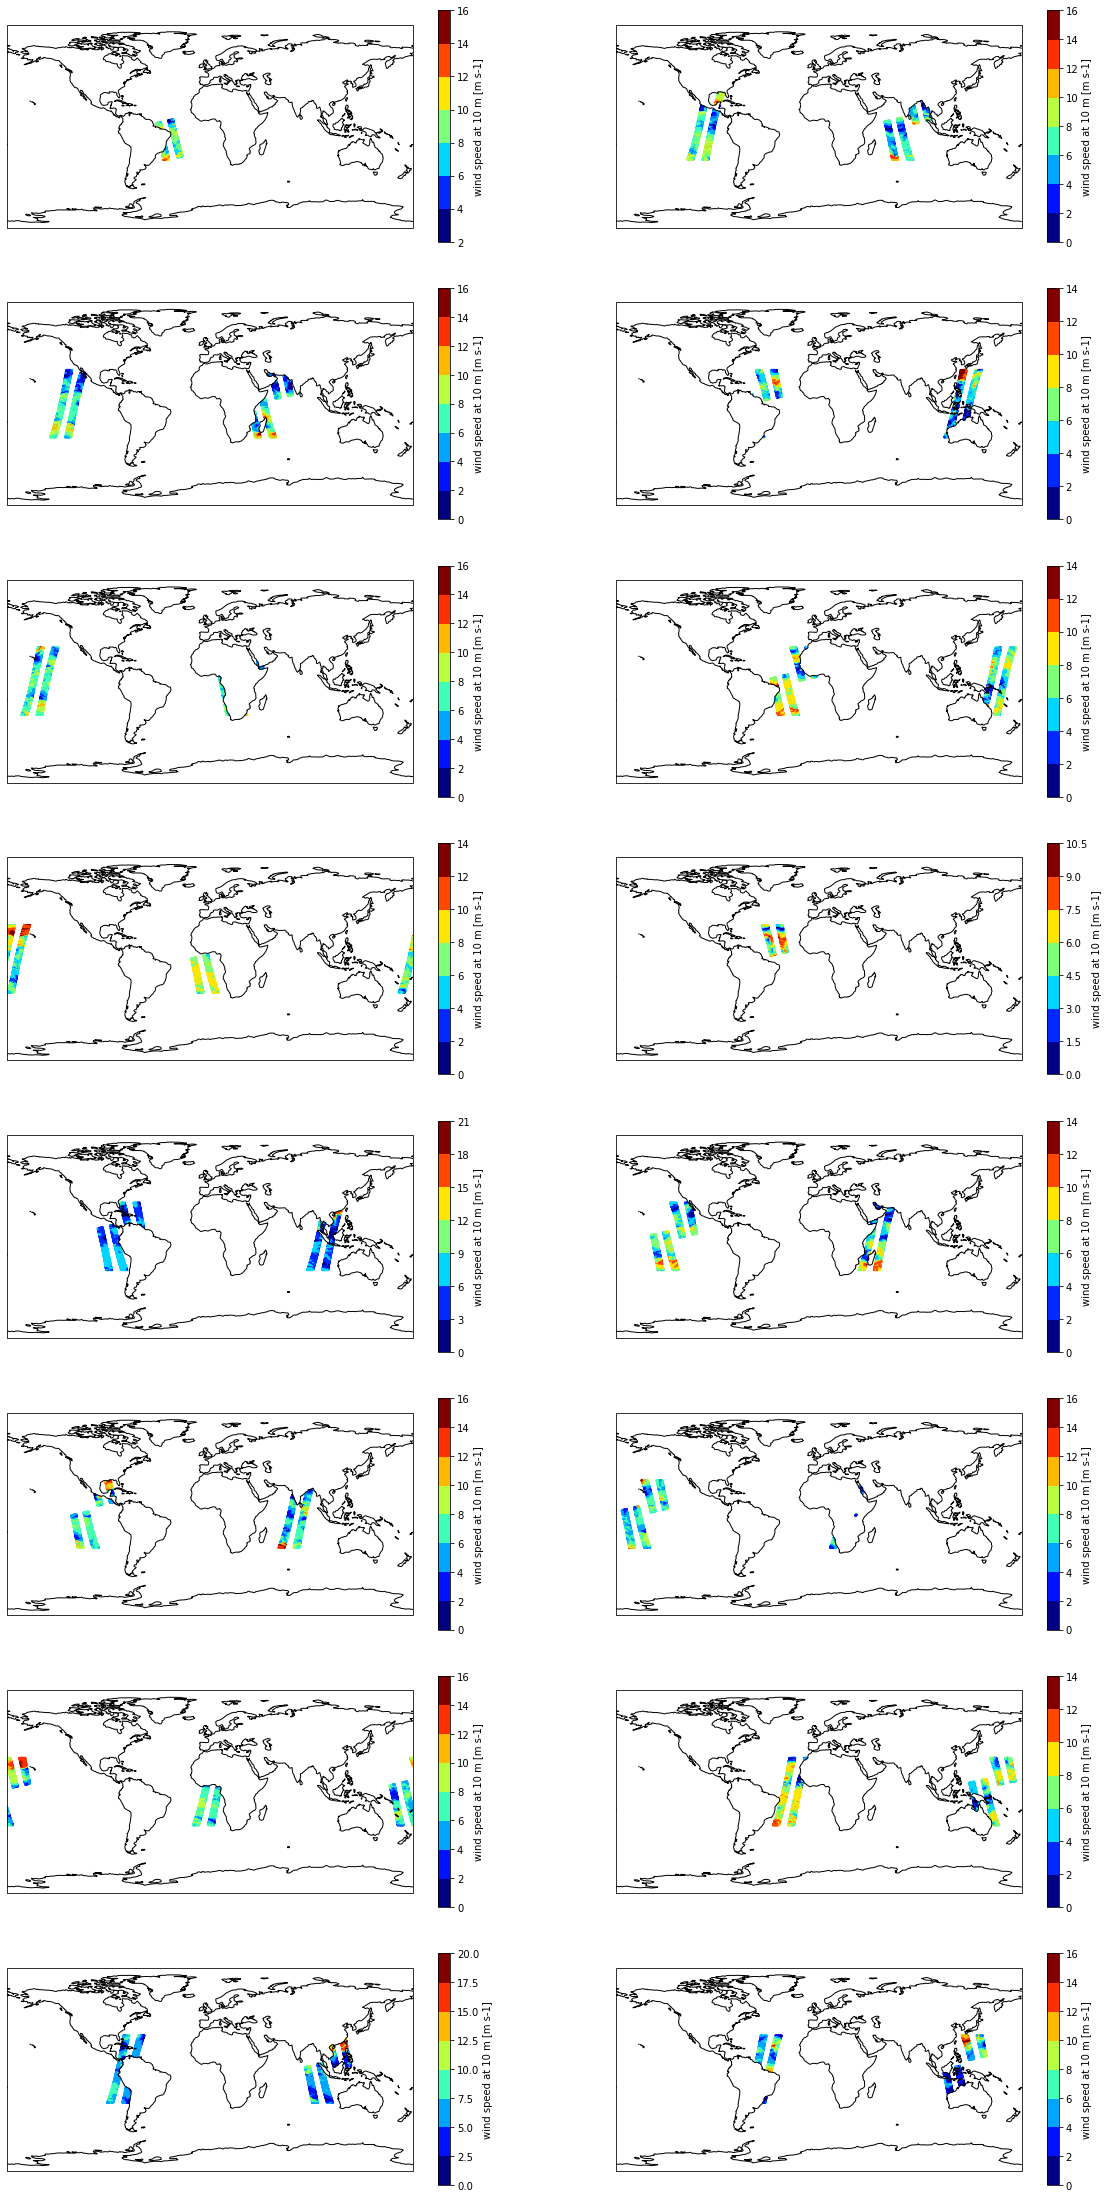

In [9]:
fig = plt.figure(figsize=(20, 40))

for index in range(0, len(ds.subset_index)):   
    ax = fig.add_subplot((len(ds.subset_index)+1)//2, 2, index+1, projection=ccrs.PlateCarree())

    p = ds.isel(subset_index=index).plot.scatter(
        y="lat",
        x="lon",
        hue="wind_speed",
        s=1,
        levels=9,
        cmap="jet",
        ax=ax
    )
    
    ax.set_global()
    ax.coastlines()

plt.show()

Plot `wind_speed` for all data in this concatenated granule on a single map. Notice that the data is within the spatial bounds we provided earlier.

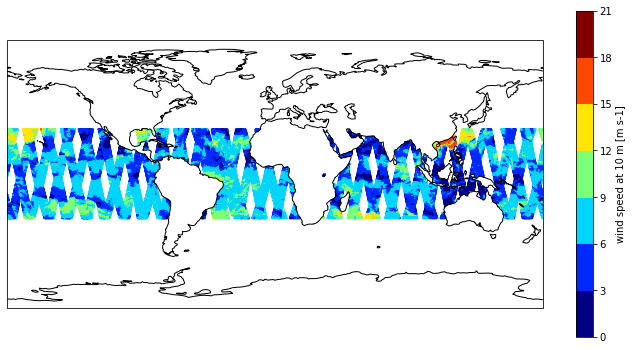

In [10]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

p = ds.plot.scatter(
    y="lat",
    x="lon",
    hue="wind_speed",
    s=1,
    levels=9,
    cmap="jet",
    ax=ax
)

ax.set_global()
ax.coastlines()
plt.show()